In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import keras

In [2]:
# import libraries to help evaluate our models
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
data = pd.read_csv('merge.csv')

data.drop(['id patient', 'Jitter (ppq5)',
         'Jitter (ddp)','Shimmer (local dB)','Shimmer (apq3)','Shimmer (apq11)',
         'Shimmer (dda)','AC','NTH','Median pitch','Standard deviation',
         'Number of pulses','Number of periods','Mean period',
         'Standard deviation of period','Fraction of locally unvoiced frames','Number of voice breaks',
         'Degree of voice breaks','UPDRS',], inplace=True, axis=1)        
        
        
data.head()

,Jitter (local),Jitter (local absolute),Jitter (rap),Shimmer (local),Shimmer (apq5),HTN,Mean pitch,Minimum pitch,Maximum pitch,class information
0,1.488,0.000090,0.900,8.334,4.609,11.130,164.781,142.229,187.576,1
1,0.728,0.000038,0.353,5.864,3.180,17.403,193.289,159.515,234.505,1
2,1.220,0.000074,0.732,8.719,5.166,12.212,164.768,146.445,211.442,1
3,2.502,0.000123,1.156,13.513,8.771,11.384,203.471,182.713,220.230,1
4,3.509,0.000167,1.715,9.112,4.927,10.653,208.440,182.821,225.162,1


In [4]:
# Separating target variable and other variables
X = data.drop(columns="class information")
y = data["class information"]

In [5]:
# Let's split the data into a train and test sets. 
# I will use the stratify parameter to maintain the ratio of classes in the dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

In [6]:
# Save the columns names as StandardScaler will strip them
X_cols = X_train.columns

# Initialize our Standard Scalar
ss = StandardScaler()

X_train = ss.fit_transform(X_train) # Fit scalar to training data and transform
X_test = ss.transform(X_test) # ONLY apply the transform to the test data

In [7]:
tf.keras.backend.set_floatx('float64')

layer_1 = tf.keras.layers.Dense(2)
layer_2 = tf.keras.layers.Dense(2, activation="softmax")

model = tf.keras.Sequential([layer_1, layer_2])
model.compile(loss="mae")

In [66]:
import pennylane as qml

n_qubits = 9
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [67]:
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

In [68]:
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

In [72]:
clayer_1 = tf.keras.layers.Dense(2)
clayer_2 = tf.keras.layers.Dense(10, activation="elu")
model = tf.keras.models.Sequential([ qlayer, qlayer, qlayer])

In [73]:
opt = tf.keras.optimizers.SGD(learning_rate=0.2)
model.compile(opt, loss="mae", metrics=["accuracy"])

In [74]:
history = model.fit(X_train, y_train, epochs=1, validation_split=0.25)

23/23 [==============================] - 376s 16s/step - loss: 0.5698 - accuracy: 0.1561 - val_loss: 0.5833 - val_accuracy: 0.1405


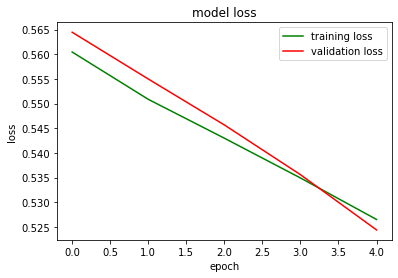

In [14]:
# ===================================================================================
#                                  Loss History Plot
# ===================================================================================

plt.title('model loss')
plt.plot(history.history['loss'], '-g', label = 'training loss')
plt.plot(history.history['val_loss'], '-r', label = 'validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

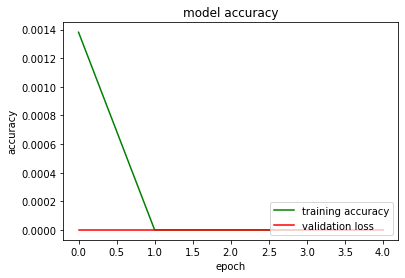

In [15]:
# ===================================================================================
#                                Accuracy History Plot
# ===================================================================================

plt.title('model accuracy')
plt.plot(history.history['accuracy'], '-g', label = 'training accuracy')
plt.plot(history.history['val_accuracy'], '-r', label = 'validation loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

In [16]:
X_test

array([[ 0.41759295,  1.04463554,  0.28671008, ..., -1.0061123 ,
        -0.82419727, -0.74946523],
       [ 0.40042726,  0.06118082,  0.77089035, ...,  0.61963034,
         0.66354522,  2.35481877],
       [ 0.53775275,  0.85597784,  0.4101923 , ..., -0.62965613,
        -1.03749994,  2.28965255],
       ...,
       [-0.8515235 , -0.98612423, -0.88095507, ...,  0.80704137,
         1.04656523, -0.02563047],
       [-0.22211498, -0.38014615, -0.6264084 , ...,  0.2742035 ,
         0.09768802,  0.02851204],
       [-0.01669893, -0.2260651 , -0.18338887, ...,  0.38287263,
         0.54949322,  0.01374987]])

In [17]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,train,test,train_y,test_y,flag=True,threshold=0.5):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    
    # Getting predictions from the model. These will come in the form of probabilities
    
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    
    # We will need to convert the probabilities into classes using a threshold, default is 0.5
    
    for i in range(len(train_y)):
        if pred_train[i]>threshold:
            pred_train[i]=1 
        else:
            pred_train[i]=0
    
    for i in range(len(test_y)):
        if pred_test[i]>threshold:
            pred_test[i]=1 
        else:
            pred_test[i]=0
        
    # Now we can calculate metircs
    
    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)
    train_recall = recall_score(train_y,pred_train)
    test_recall = recall_score(test_y,pred_test)
    
    train_precision = precision_score(train_y,pred_train)
    test_precision = precision_score(test_y,pred_test)
    
    train_f1 = f1_score(train_y,pred_train)
    test_f1 = f1_score(test_y,pred_test)
    
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1))
        
     # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",accuracy_score(pred_train,train_y))
        print("Accuracy on test set : ",accuracy_score(pred_test,test_y))
        print("Recall on training set : ",recall_score(train_y,pred_train))
        print("Recall on test set : ",recall_score(test_y,pred_test))
        print("Precision on training set : ",precision_score(train_y,pred_train))
        print("Precision on test set : ",precision_score(test_y,pred_test))
        print("F1 on training set : ",f1_score(train_y,pred_train))
        print("F1 on test set : ",f1_score(test_y,pred_test))
    
    #return score_list # returning the list with train and test scores

In [18]:
## This function is exactly the same as the last, only it will NOT use the test data
## There will be many times that we want to look at training metrics without looking at test metrics 
## This is to avoid tuning the model on the test data

##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_training_metrics(model,train,train_y,flag=True,threshold=0.5):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    
    # Getting predictions from the model. These will come in the form of probabilities
    
    pred_train = model.predict(train)
    
    # We will need to convert the probabilities into classes using a threshold, default is 0.5
    
    for i in range(len(train_y)):
        if pred_train[i]>threshold:
            pred_train[i]=1 
        else:
            pred_train[i]=0
          
    # Now we can calculate metircs
    
    train_acc = accuracy_score(pred_train,train_y)
    train_recall = recall_score(train_y,pred_train)
    train_precision = precision_score(train_y,pred_train)
    train_f1 = f1_score(train_y,pred_train)
   
    score_list.extend((train_acc,train_recall,train_precision,train_f1))
        
     # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",accuracy_score(pred_train,train_y))
        print("Recall on training set : ",recall_score(train_y,pred_train))
        print("Precision on training set : ",precision_score(train_y,pred_train))
        print("F1 on training set : ",f1_score(train_y,pred_train))

In [19]:
# This function returns the optimum output from the ROC curve given a model.
def get_optimal(model):
    y_probs = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

In [20]:
def make_confusion_matrix(model,test_X,y_actual,labels=[1, 0],threshold=0.5):
    '''
    model : classifier to predict values of X
    y_actual : ground truth
    threshold : value used to convert probabilites to classes. Range = 0-1
    
    '''
    # Our model will output probabilities we will convert these to classes using a threshold (dafault is 0.5)
    y_predict = model.predict(test_X)
    
    for i in range(len(y_actual)):
        if y_predict[i]>threshold:
            y_predict[i]=1 
        else:
            y_predict[i]=0
    
    # We can now plot the confusion matrix    
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
def make_ROC(model):
    # Calculate the False Postive Rate, True Positive Rate, ROC curve and area under ROC curve
    y_probs = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
    roc_auc = metrics.auc(fpr, tpr)

    # Now plot the information calculated above
    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Now print the optimal threshold
    # The optimal cut off would be where tpr is high and fpr is low
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print('The optimal threshold is:', optimal_threshold)

In [22]:
#This function will plot the training and validation loss vs. training epoch
def get_history_plot(n):
    N = n
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Validation loss on the dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("train_Loss/val_loss")
    plt.legend()
    plt.show()

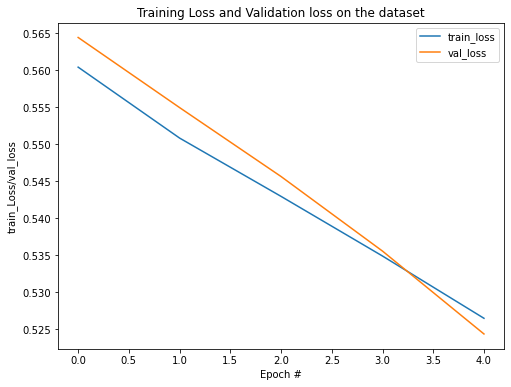

In [23]:
get_history_plot(5)

In [39]:
print(y_train.shape)

(966,)


In [48]:
X_test

array([[ 0.41759295,  1.04463554,  0.28671008, ..., -1.0061123 ,
        -0.82419727, -0.74946523],
       [ 0.40042726,  0.06118082,  0.77089035, ...,  0.61963034,
         0.66354522,  2.35481877],
       [ 0.53775275,  0.85597784,  0.4101923 , ..., -0.62965613,
        -1.03749994,  2.28965255],
       ...,
       [-0.8515235 , -0.98612423, -0.88095507, ...,  0.80704137,
         1.04656523, -0.02563047],
       [-0.22211498, -0.38014615, -0.6264084 , ...,  0.2742035 ,
         0.09768802,  0.02851204],
       [-0.01669893, -0.2260651 , -0.18338887, ...,  0.38287263,
         0.54949322,  0.01374987]])

In [53]:
X_test[0]

array([ 0.41759295,  1.04463554,  0.28671008,  0.76672317,  0.50085469,
       -0.50917245, -1.0061123 , -0.82419727, -0.74946523])

In [54]:
model.predict(X_test)

array([[0.46599541, 0.33048421, 0.3332884 , ..., 0.36033064, 0.21193695,
        0.57377362],
       [0.37214938, 0.42896752, 0.48596698, ..., 0.29354899, 0.36551477,
        0.43029525],
       [0.42627608, 0.38241441, 0.41341437, ..., 0.32821446, 0.28331038,
        0.51451347],
       ...,
       [0.39559632, 0.42478115, 0.47871699, ..., 0.30255994, 0.33984264,
        0.46906262],
       [0.47175514, 0.35784617, 0.37446446, ..., 0.35187429, 0.22328628,
        0.58735676],
       [0.46023683, 0.35651839, 0.37290523, ..., 0.34871958, 0.23379303,
        0.56782833]])

In [59]:
y_predict = model.predict(X_test)

def preb(model,test_X,y_actual,labels=[1, 0],threshold=0.5):
    for i in range(len(y_actual)):
            if (y_predict[i]>threshold).any():
                y_predict[i]=1 
            else:
                y_predict[i]=0
    return y_predict

In [60]:
x_preb= preb(model,X_test,y_test,threshold=0.5)

In [61]:
x_preb

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [47]:
y_test

687     0
444     1
39      1
1048    1
26      1
       ..
447     1
350     1
705     0
758     0
518     1
Name: class information, Length: 242, dtype: int64

In [41]:
print(X_train.shape)

(966, 9)


In [51]:
print(X_test.shape)

(242, 9)


In [42]:
print(classification_report(y_train, y_train, labels=[0, 1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       416
           1       1.00      1.00      1.00       550

    accuracy                           1.00       966
   macro avg       1.00      1.00      1.00       966
weighted avg       1.00      1.00      1.00       966



In [46]:
make_confusion_matrix(model,X_test,y_test,threshold=0.5)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
get_metrics_score(model,X_train,X_test,y_train,y_test,threshold=0.5)

In [ ]:
make_ROC(model)

In [ ]:
optimal = get_optimal(history)
get_metrics_score(model16,X_train,X_test,y_train,y_test,threshold=optimal)